Gene Ontology aided Compound Protein Binding
Affinity Prediction Using Neural Network

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Input # type: ignore
from tensorflow.keras.layers import BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve, auc

Loading data

In [2]:
df_davis = pd.read_csv("davis-filter.txt", header=None, sep=" ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])
df_kiba = pd.read_csv("kiba.txt", header=None,sep = " ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])

In [3]:

#check for any missing values in train data
print(df_davis.isnull().any().sum())
#check for any missing values in train data
print(df_kiba.isnull().any().sum())

0
0


Merging the datasets

In [4]:
df = df_davis
df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,11314340,AKT1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186
2,11314340,AKT2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602
3,11314340,AKT3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727
4,11314340,AURKC,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721
...,...,...,...,...,...
9120,151194,PDGFRB,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060
9121,151194,RET(M918T),C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186
9122,151194,VEGFR2,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608
9123,151194,YSK4,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246


Using One-Hot encoding for SMILES and AMINO ACIDS sequence

In [5]:
#for amino acid sequence
# Step 1: Extract unique characters from the specified column ('amino_acid_seq')
unique_chars = sorted(set(''.join(df['amino_acid_seq'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['amino_acid_seq_encoded'] = df['amino_acid_seq'].apply(encode_sequence)

#for SMILES sequence
# Step 1: Extract unique characters from the specified column ('SMILES_seq_drug')
unique_chars = sorted(set(''.join(df['SMILES_seq_drug'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['SMILES_seq_drug_encoded'] = df['SMILES_seq_drug'].apply(encode_sequence)


Padding the amino acid and smiles sequences with 0's to ensure uniformity

In [6]:
# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['amino_acid_seq_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['aa_seq_padded'] = list(padded_seqs)

# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['SMILES_seq_drug_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['smiles_seq_padded'] = list(padded_seqs)

#join the padded sequences
df['drug_protein_encoded'] = df.apply(lambda row: np.concatenate([row['aa_seq_padded'], row['smiles_seq_padded']]), axis = 1)

df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score,amino_acid_seq_encoded,SMILES_seq_drug_encoded,aa_seq_padded,smiles_seq_padded,drug_protein_encoded
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1..."
1,11314340,AKT1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186,"[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ..."
2,11314340,AKT2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602,"[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,..."
3,11314340,AKT3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727,"[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14..."
4,11314340,AURKC,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721,"[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ..."
...,...,...,...,...,...,...,...,...,...,...
9120,151194,PDGFRB,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060,"[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ..."
9121,151194,RET(M918T),C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186,"[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ..."
9122,151194,VEGFR2,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608,"[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ..."
9123,151194,YSK4,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246,"[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16..."


Train-test splitting – Case 1
Proteins in test set are already seen in the train set


In [7]:

# Define the split function for each protein
def split_protein_data(group):
    # Number of interactions per protein
    n = len(group)

    # Determine how many interactions to include in training (70%)
    train_size = int(0.7 * n)
    
    # Randomly shuffle and split the data
    train_group = group.sample(train_size, random_state=42)
    test_group = group.drop(train_group.index)
    
    return train_group, test_group

# Apply the splitting function to each protein group
train_list = []
test_list = []

for protein, group in df.groupby('protein_id'):
    n = len(group)
    if(n==1): continue
    train_group, test_group = split_protein_data(group)
    train_list.append(train_group)
    test_list.append(test_group)

# Concatenate the training and test sets
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Shuffle the final train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


Checking whether the split happened properly

In [8]:
column_values_1 = set(sorted(train_df['protein_id'].tolist()))
column_values_2 = set(sorted(test_df['protein_id'].tolist()))

print(column_values_1 == column_values_2)

True


Building the Neural Network

In [55]:
model = Sequential()

model.add(Input(shape=(2641,)))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))

Compiling the model

In [56]:
#Optimizer
optimizer = Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 1024)           │     2,705,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,990,753 (11.41 MB)

 Trainable params: 2,988,033 (11.40 MB)

 Non-trainable params: 2,720 (10.62 KB)

Training the model

In [57]:
x_train = train_df['drug_protein_encoded']
x_train = pad_sequences(x_train, padding='post', dtype='int8')
y_train = train_df['affinity_score']

x_test = test_df['drug_protein_encoded']
x_test = pad_sequences(x_test, padding='post', dtype='int8')
y_test = test_df['affinity_score']

batch_size = 300
epochs = 30

customLR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
)

history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test), verbose=1, callbacks = [customLR])

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 31.9786 - mae: 5.3548 - val_loss: 3674.4934 - val_mae: 54.9462 - learning_rate: 0.0300
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 2.9152 - mae: 1.4764 - val_loss: 234.9849 - val_mae: 13.8416 - learning_rate: 0.0300
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 1.4245 - mae: 0.8937 - val_loss: 46.7182 - val_mae: 6.3335 - learning_rate: 0.0300
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 1.0548 - mae: 0.8115 - val_loss: 12.3902 - val_mae: 3.2456 - learning_rate: 0.0300
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 1.0207 - mae: 0.8054 - val_loss: 4.1611 - val_mae: 1.7836 - learning_rate: 0.0300
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.9530 - mae: 0.7711 - val_loss: 2.5285 - val_mae: 1.2939 - learning_rate: 0.0300
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.9326 - mae: 0.7556 - val_loss: 1.9582 - val_mae: 1.1312 - learning_rate: 0.

Evaluating the Model

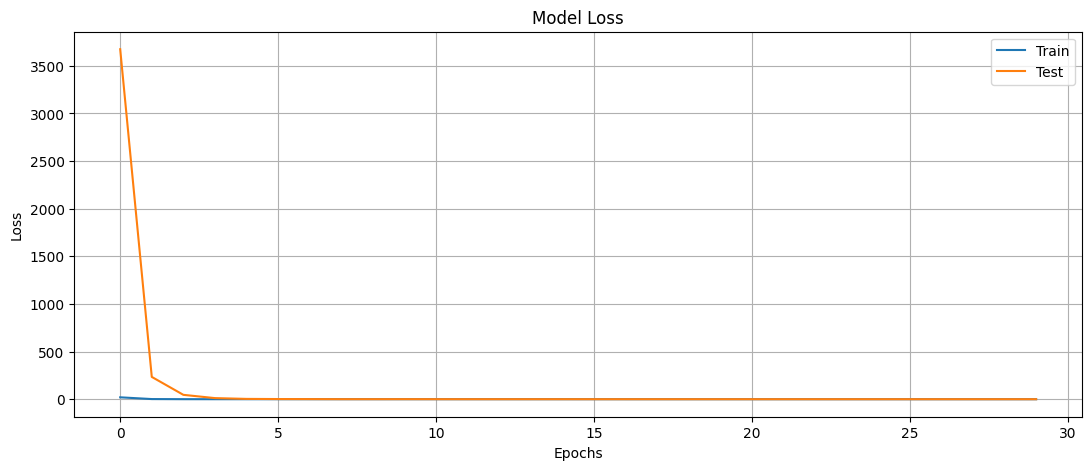

In [58]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

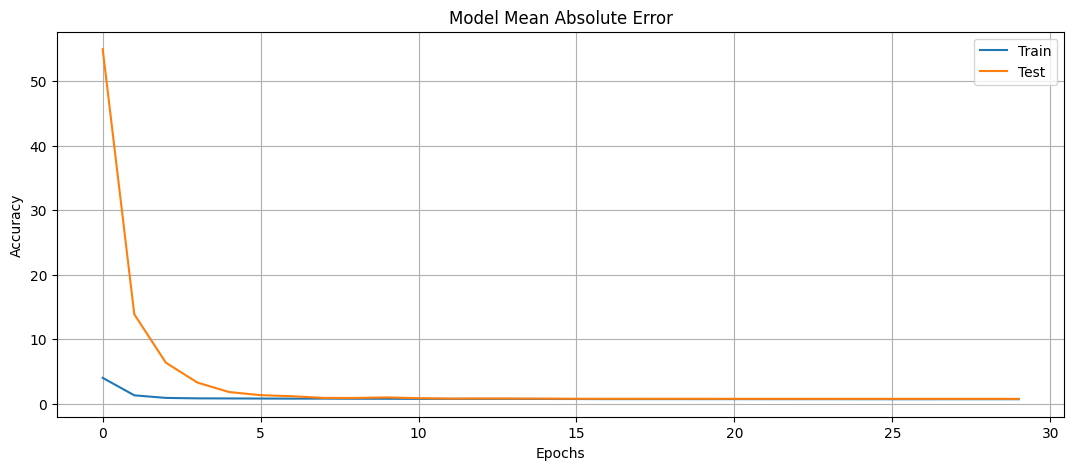

In [59]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

Measuring the performance of model

In [60]:
y_pred = model.predict(x_test).flatten()

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [61]:
# Looking at the predictions
for i in range(len(y_pred)):
    print("actual: ", y_test[i], "predicted: ", y_pred[i])

actual:  5.522878745280337 predicted:  6.0988517
actual:  6.376750709602099 predicted:  6.026797
actual:  5.619788758288394 predicted:  5.885925
actual:  5.568636235841013 predicted:  5.9984303
actual:  7.67778070526608 predicted:  6.9332604
actual:  6.031517051446065 predicted:  6.145837
actual:  5.537602002101044 predicted:  6.204943
actual:  5.958607314841775 predicted:  6.235582
actual:  5.292429823902063 predicted:  6.2301717
actual:  10.4089353929735 predicted:  7.4436836
actual:  7.275724130399211 predicted:  7.426494
actual:  8.346787486224656 predicted:  6.371249
actual:  6.1249387366083 predicted:  5.9029613
actual:  6.481486060122113 predicted:  6.417519
actual:  5.568636235841013 predicted:  6.193579
actual:  6.958607314841775 predicted:  6.410278
actual:  5.026872146400302 predicted:  5.546122
actual:  8.214670164989233 predicted:  6.9843354
actual:  6.657577319177793 predicted:  6.1909485
actual:  6.173925197299174 predicted:  5.951705
actual:  8.431798275933005 predicted

In [62]:

# Calculate the C-Index
ci = concordance_index(y_test, y_pred)
print("concordance index: " , ci)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("mean_squared_error: ", mse)

# Calculate pearson correlation
pearson_corr, p_value = pearsonr(y_test, y_pred)
print("pearson correlation: ", pearson_corr)

concordance index:  0.6408300504764856
mean_squared_error:  0.889318040950815
pearson correlation:  0.4413922325437309
